# Libraries

In [1]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import os
from glob import glob
from tqdm import tqdm
from torchvision import transforms
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import albumentations as A
from albumentations.pytorch import ToTensorV2
import time
import sys
from operator import add

from torch.autograd import Variable
%matplotlib inline

In [2]:
import torch.nn as nn
import torch.nn.functional as F

import time
import os
import datetime
import pytz
import random

In [3]:
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score

## Constants

In [4]:
num_clients = 1
cut_layer = 1
train_images = 20
epochs = 10
batch_size = 8
lr = 1e-4

subset_mode = False
mod = True

## Paths

In [5]:
images_PATH = '../input/chest-xray-masks-and-labels/Lung Segmentation/'
# image_path_test = '../input/chest-xray-masks-and-labels/Lung Segmentation/test/' 
checkpoint_PATH = 'unet_split'
checkpoint_PATH = checkpoint_PATH + "_" + "cut_layer_" + str(cut_layer) + "_" + str(train_images) + "_images_" + str(epochs) + "_epochs" 
print(checkpoint_PATH)
results_PATH = './'

unet_split_cut_layer_1_20_images_10_epochs


## Transforms

In [6]:
mean0_1, std0_1 = [0.0, 0.0, 0.0], [1.0, 1.0, 1.0]
mean_imgnet, std_imgnet = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
mean1_1gray, std1_1gray = [0.5, ], [0.5, ]
dim = 256

image_tfms = transforms.Compose([
    transforms.Resize((dim, dim)),
    transforms.ToTensor(),
    transforms.Normalize(mean = mean1_1gray, 
                         std = std1_1gray)
])

mask_tfms = transforms.Compose([
    transforms.Resize((dim, dim)),
    transforms.ToTensor()
])

# Load Data, Trainloader

In [7]:
images = os.listdir(images_PATH+'CXR_png/')
mask = os.listdir(images_PATH+'masks/')
mask = [fName.split(".png")[0] for fName in mask]
image_file_name = [fName.split("_mask")[0] for fName in mask]

check = [i for i in mask if "mask" in i]

In [8]:
testing_files = set(os.listdir(images_PATH+'CXR_png/')) & set(os.listdir(images_PATH+'masks/'))
training_files = check

## Dataset Class

In [9]:
class SegmentationDS(Dataset):
    """ create dataset by using image path and their labels """
    def __init__ (self, path, files, flag = "MONT", transform = (None, None)):
        self.path = images_PATH
        self.files = files
        self.flag = flag
        self.transform = transform

        
    def __len__(self):
        return len (self.files)

    def __getitem__(self, index):
        
        f = sorted(list(self.files))
        if self.flag == "MONT":    
            image = Image.open(os.path.join(self.path, "CXR_png", f[index])).convert('L')
            mask = Image.open(os.path.join(self.path, "masks", f[index])).convert('L')

        elif self.flag == "SHEN":
            image = Image.open(os.path.join(self.path, "CXR_png", f[index].split("_mask")[0] + ".png")).convert('L')
            mask = Image.open(os.path.join(self.path, "masks", f[index] + ".png")).convert('L')


        if self.transform != (None, None):
            image = self.transform[0](image)
            mask = self.transform[1](mask)
            
        return image, mask

In [10]:
Mont_ds = SegmentationDS(images_PATH, testing_files, flag = "MONT", transform = (image_tfms, mask_tfms))
Shen_ds = SegmentationDS(images_PATH, training_files, flag = "SHEN", transform = (image_tfms, mask_tfms))

In [11]:
print(type(Mont_ds))
len(Mont_ds), len(Shen_ds)

<class '__main__.SegmentationDS'>


(138, 566)

In [12]:
def imshow (img, mean_set, std_set):
    """ visualize torch tensor image """
    
    if img.shape[0] == 3:
        img = img.numpy ().transpose (1, 2, 0)
        mean = mean_set
        std = std_set
        img = img * std + mean
        img = np.clip (img, 0, 1)
        plt.figure (figsize = (5, 5))
        plt.imshow (img)
        
    elif img.shape[0] == 1:
        img = img.numpy ().transpose (1, 2, 0)
        mean = mean_set
        std = std_set
        img = img * std + mean
        img = np.clip (img, 0, 1)
    
        plt.figure (figsize = (5, 5))
        plt.imshow (img,cmap='gray')

torch.Size([1, 256, 256])
torch.Size([1, 256, 256])
tensor(-1.) tensor(1.)
tensor(0.) tensor(1.)


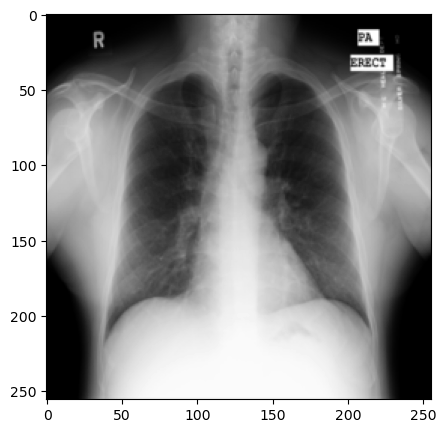

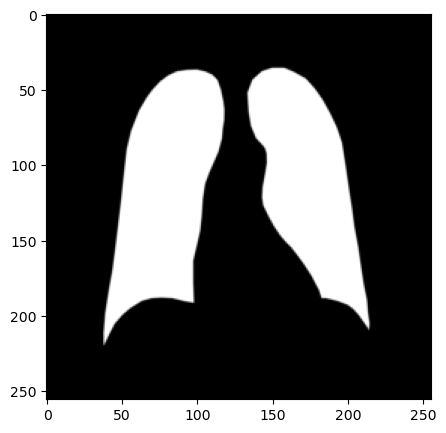

In [13]:
idx = np.random.choice (len (Mont_ds))
img, lbl = Mont_ds [idx]
print (img.shape)
print (lbl.shape)
print(img.min(), img.max())
print(lbl.min(), lbl.max())
imshow(img, mean1_1gray, std1_1gray)
imshow(lbl, mean1_1gray, std1_1gray)

## Subset DS, Trainloader (For debugging)

In [14]:
train_ds = torch.utils.data.ConcatDataset([Mont_ds, Shen_ds])

if subset_mode == True:
    train_ds = torch.utils.data.Subset(train_ds, indices = [i for i in range(train_images)])
    
elif subset_mode == False:
    train_images = len(train_ds)

# print("TRAIN IMAGES: ", len(train_ds))

In [15]:
checkpoint_PATH = 'unet_split'
checkpoint_PATH = checkpoint_PATH + "_" + "cut_layer_" + str(cut_layer) + "_" + str(train_images) + "_images_" + str(epochs) + "_epochs" 
print(checkpoint_PATH)

unet_split_cut_layer_1_704_images_10_epochs


In [16]:
train_size = int(0.80 * len(train_ds))
valid_size = len(train_ds) - train_size
train_ds, valid_ds = torch.utils.data.random_split(train_ds, [train_size, valid_size])

print(len(train_ds), len(valid_ds))
print("TRAIN IMAGES: ", len(train_ds))
print("VAL IMAGES: ", len(valid_ds))

563 141
TRAIN IMAGES:  563
VAL IMAGES:  141


In [17]:
print(checkpoint_PATH)

unet_split_cut_layer_1_704_images_10_epochs


## Trainloaders

In [18]:
train_dl = DataLoader (train_ds, batch_size = 8, shuffle = True)
valid_dl = DataLoader (valid_ds, batch_size = 8, shuffle = True)

# MCOZ PLBS

## Loss Function

In [19]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)

        return 1 - dice

class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss

        return Dice_BCE

## Metrics

In [20]:
def calculate_metrics(y_pred, y_true):
    """ Ground truth """
    y_true = y_true.cpu().numpy()
    y_true = y_true > 0.5
    y_true = y_true.astype(np.uint8)
    y_true = y_true.reshape(-1)

    """ Prediction """
    y_pred = y_pred.cpu().detach().numpy()
    y_pred = y_pred > 0.5
    y_pred = y_pred.astype(np.uint8)
    y_pred = y_pred.reshape(-1)

    score_jaccard = jaccard_score(y_true, y_pred)
#     score_f1 = f1_score(y_true, y_pred)
#     score_recall = recall_score(y_true, y_pred)
#     score_precision = precision_score(y_true, y_pred)
    score_acc = accuracy_score(y_true, y_pred)

    return [score_jaccard, score_acc]

In [21]:
try:
    from torchsummary import summary
except ImportError:
    !pip3 -q install torchsummary
    from torchsummary import summary

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## U-Net Model

In [23]:
class conv_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)

        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_c)

        self.relu = nn.ReLU()

    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        return x

class encoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv = conv_block(in_c, out_c)
        self.pool = nn.MaxPool2d((2, 2))

    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)

        return x, p

class decoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        self.conv = conv_block(out_c+out_c, out_c)

    def forward(self, inputs, skip):
        x = self.up(inputs)
        x = torch.cat([x, skip], axis=1)
        x = self.conv(x)
        return x

## Old (Client, Server Classes) - Hardcoded

In [24]:
class Unet_Client_Encoder(nn.Module):
    def __init__(self, input_channel:int = 3, output_channel:int = 1):
        super().__init__()

        """ Encoder """
        self.e1 = encoder_block(input_channel, 64)
        self.e2 = encoder_block(64, 128)

    def forward(self, inputs):
        """ Encoder """
        s1, p1 = self.e1(inputs)
        s2, p2 = self.e2(p1)

        return p2, [s1, s2]
    
    
class Unet_Server_Widow(nn.Module):
    def __init__(self, input_channel:int = 3, output_channel:int = 1):
        super().__init__()

        self.e3 = encoder_block(128, 256)
        self.e4 = encoder_block(256, 512)

        self.b = conv_block(512, 1024)

        self.d1 = decoder_block(1024, 512)
        self.d2 = decoder_block(512, 256)

    def forward(self, inputs):
        s3, p3 = self.e3(inputs)
        s4, p4 = self.e4(p3)

        """ Bottleneck """
        b = self.b(p4)

        """ Decoder """
        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)

        return d2
    
class Unet_Client_Decoder(nn.Module):
    def __init__(self, input_channel:int = 3, output_channel:int = 1):
        super().__init__()
        self.d3 = decoder_block(256, 128)
        self.d4 = decoder_block(128, 64)

        """ Classifier """
        self.outputs = nn.Conv2d(64, output_channel, kernel_size=1, padding=0)

    def forward(self, inputs, skips):
        print("In CLient DECCCCC OLD", skips.shape)
        print(inputs.shape)
#         print(skips[1].shape)
#         print(skips[0].shape)
        print()
        d3 = self.d3(inputs, skips[1])
        print(d3.shape)
        d4 = self.d4(d3, skips[0])
        print(d4.shape)
        print("____________________________________")

        outputs = self.outputs(d4)

        return outputs


## Modular Classes 

In [25]:
input_channel:int = 1
output_channel:int = 1

encoder_channels = [input_channel,64,128,256,512,1024]
decoder_channels = [1024, 512, 256, 128, 64, output_channel]

# cut_layer = cut_layer # This means, Client_Encoder should contain encoders for (input_channel, 64), and (64, 128) {Upto 3rd element of encoder_channels}

# print([(encoder_channels[i], encoder_channels[i+1]) for i in range(len(encoder_channels) - 2) ]) # Encoder blocks
# print((encoder_channels[len(encoder_channels)-2], encoder_channels[len(encoder_channels)-1])) # Bottleneck

# print([(decoder_channels[i], decoder_channels[i+1]) for i in range(len(decoder_channels) - 2) ]) # Decoder blocks
# print((decoder_channels[len(decoder_channels)-2], decoder_channels[len(decoder_channels)-1])) # Output layer

### Model Summary

In [26]:
def verbose_model_summary(encoder_channels, decoder_channels, cut_layer):
    e_channels = encoder_channels
    d_channels = decoder_channels

    cut_layer = cut_layer
    print("Cut Layer: ", cut_layer)

    ne = len(e_channels) # No. of Encoder Channels
    nd = len(d_channels) # No. of Decoder Channels

    encoder_list = [encoder_block(e_channels[i], e_channels[i+1]) for i in range(ne - 2)]
    bottleneck = conv_block(e_channels[ne - 2], e_channels[ne - 1]) # Second last, and last channel (512, 1024)
    decoder_list = [decoder_block(d_channels[i], d_channels[i+1]) for i in range(nd - 2)]
    output_layer = nn.Conv2d(d_channels[nd-2], d_channels[nd-1], kernel_size=1, padding=0)
    
    print("===========================================================================================================")
    print("CLIENT ENCODER")
    print("_____________________________________________________________________________")
    print(encoder_list[0:cut_layer]) # CE 
    # cut_layer = 2 Means First two (in the entire U-Net)
    print("===========================================================================================================")
    print()
    
    print("SERVER WIDOW")
    print("_____________________________________________________________________________")
    print(encoder_list[cut_layer:]) # SW
    print("_____________________________________________________________________________")
    print(bottleneck)
    print("_____________________________________________________________________________")
    print(decoder_list[:-(cut_layer)])
    print("===========================================================================================================")
    print()
    
    print("CLIENT DECODER")
    print("_____________________________________________________________________________")
    print(decoder_list[-(cut_layer):]) # CD
    # cut_layer = 2 Means Last two (in the entire U-Net)
    print("_____________________________________________________________________________")
    print(output_layer)
    print("===========================================================================================================")

In [27]:
verbose_model_summary(encoder_channels, decoder_channels, cut_layer = cut_layer)

Cut Layer:  1
CLIENT ENCODER
_____________________________________________________________________________
[encoder_block(
  (conv): conv_block(
    (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
)]

SERVER WIDOW
_____________________________________________________________________________
[encoder_block(
  (conv): conv_block(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): B

## Same Constructors, Diff. Forward() functions for the 3 Modular classes!!

In [28]:
class Unet_Client_Encoder_Mod(nn.Module):
    def __init__(self, input_channel:int = 3, output_channel:int = 1, cut_layer = 3):
        super().__init__()
        
        
        self.cut_layer = cut_layer
        e_channels = [input_channel,64,128,256,512,1024] # Last channel reserved for bottleneck, others for encoder_blocks

        ne = len(e_channels) # No. of Encoder Channels

        self.encoder_list = nn.ModuleList([encoder_block(e_channels[i], e_channels[i+1]) for i in range(ne - 2)])
        
        # Unused Components
        # d_channels = [1024, 512, 256, 128, 64, output_channel]
        # nd = len(d_channels) # No. of Decoder Channels
        # self.bottleneck = conv_block(e_channels[ne - 2], e_channels[ne - 1]) # Second last, and last channel (512, 1024)
        # self.decoder_list = nn.ModuleList([decoder_block(d_channels[i], d_channels[i+1]) for i in range(nd - 2)])
        # self.output_layer = nn.Conv2d(d_channels[nd-2], d_channels[nd-1], kernel_size=1, padding=0) # Second last, and last channel (64, 1)

    def forward(self, inputs):
    # Encoder
        skips = [] # These will be used by the decoder blocks later (in reverse order)
    
        for i in range(0,self.cut_layer): # Cut_Layer = 2 means first 2 of the decoder blocks (1, 64), (64, 128)
            if i == 0: # To initialize s and p
                s, p = self.encoder_list[i](inputs)
            else:
                s, p = self.encoder_list[i](p)
            skips.append(s)
        
        return p, skips
# _______________________________________________________________________________________________________
    
class Unet_Server_Widow_Mod(nn.Module):
    def __init__(self, input_channel:int = 3, output_channel:int = 1, cut_layer = 3):
        super().__init__()

        self.cut_layer = cut_layer
        e_channels = [input_channel,64,128,256,512,1024]
        d_channels = [1024, 512, 256, 128, 64, output_channel]

        ne = len(e_channels) # No. of Encoder Channels
        nd = len(d_channels) # No. of Decoder Channels

        self.encoder_list = nn.ModuleList([encoder_block(e_channels[i], e_channels[i+1]) for i in range(ne - 2)])
        self.bottleneck = conv_block(e_channels[ne - 2], e_channels[ne - 1]) # Second last, and last channel (512, 1024)
        self.decoder_list = nn.ModuleList([decoder_block(d_channels[i], d_channels[i+1]) for i in range(nd - 2)])
        
        # Unused Components
        # self.output_layer = nn.Conv2d(d_channels[nd-2], d_channels[nd-1], kernel_size=1, padding=0) # Second last, and last channel (64, 1)

    def forward(self, inputs):
    # Encoder        
        skips = []
        count = 0
        for i in range(self.cut_layer, len(self.encoder_list)):
            if count == 0: # Need to check 'count' for zero, because if we check i, s and p will never be initialized!
                s, p = self.encoder_list[i](inputs)
            else:
                s, p = self.encoder_list[i](p)
            
            skips.append(s)
            count = count + 1
    # Bottleneck
        b = self.bottleneck(p)
                
    # Decoder
        skips = skips[::-1] # Reverse the list!! We received [s3, s4], we need to use it in the order [s4, s3]
    
        for i in range(0, len(self.decoder_list)-self.cut_layer):
            if i == 0: # To initialize d
                d = self.decoder_list[i](b, skips[i])
            else:
                d = self.decoder_list[i](d, skips[i])
            
        return d
# _______________________________________________________________________________________________________
    
class Unet_Client_Decoder_Mod(nn.Module):
    def __init__(self, input_channel:int = 3, output_channel:int = 1, cut_layer = 3):
        super().__init__()

        self.cut_layer = cut_layer
        d_channels = [1024, 512, 256, 128, 64, output_channel] # Last "output_channel" is reserved for output_layer
        nd = len(d_channels) 
        
        self.decoder_list = nn.ModuleList([decoder_block(d_channels[i], d_channels[i+1]) for i in range(nd - 2)]) # (1024, 512),..., (128, 64)
        self.output_layer = nn.Conv2d(d_channels[nd-2], d_channels[nd-1], kernel_size=1, padding=0) # Second last, and last channel (64, 1)

        # Unused Components
        # e_channels = [input_channel,64,128,256,512,1024]
        # ne = len(e_channels) # No. of Encoder Channels
        # self.encoder_list = nn.ModuleList([encoder_block(e_channels[i], e_channels[i+1]) for i in range(ne - 2)])
        # self.bottleneck = conv_block(e_channels[ne - 2], e_channels[ne - 1]) # Second last, and last channel (512, 1024)


    def forward(self, inputs, skips):
    # Decoder
        skips = skips[::-1] # Reverse The List (We got [s1, s2], but we need to use it in the order [s2, s1])            
        count = 0
        
        for i in range(len(self.decoder_list)-self.cut_layer, len(self.decoder_list)): # Cut_layer = 2 means last 2 decoder_blocks
            if count == 0: # Need to check 'count' for zero, because if we check i, d will never be initialized!
                d = self.decoder_list[i](inputs, skips[count])
            else:
                d = self.decoder_list[i](d, skips[count])
            count = count + 1
        
        outputs = self.output_layer(d)
        
        return outputs


In [29]:
print("Cut Layer is : ", cut_layer)

Cut Layer is :  1


In [30]:
print(device)

# mod = False
mod = mod

if mod == False:
    uce_model = Unet_Client_Encoder(input_channel=1, output_channel=1) # M
    usw_model = Unet_Server_Widow(input_channel=1, output_channel=1) # M
    ucd_model = Unet_Client_Decoder(input_channel=1, output_channel=1) # M

if mod == True:
    uce_model = Unet_Client_Encoder_Mod(input_channel=1, output_channel=1, cut_layer = cut_layer) # M
    usw_model = Unet_Server_Widow_Mod(input_channel=1, output_channel=1, cut_layer = cut_layer) # M
    ucd_model = Unet_Client_Decoder_Mod(input_channel=1, output_channel=1, cut_layer = cut_layer) # M

uce_model = uce_model.to(device) # M
usw_model = usw_model.to(device) # M
ucd_model = ucd_model.to(device) # M

models = [uce_model, usw_model, ucd_model]

cuda


In [31]:
# y_pred, skip = deb(models)

In [32]:
# def deb(models):
#     x = torch.rand(1, 1, 256, 256)
#     x = x.to(device)
#     client_enc, server, client_dec = models
#     x1, skip = uce_model(x)
#     x2 = usw_model(x1)
#     y_pred = ucd_model(x2, skip)
#     print(y_pred.shape)
    
#     return y_pred, skip

In [33]:
loss_fn = DiceBCELoss() # C

ce_optimizer = torch.optim.Adam(uce_model.parameters(), lr=lr) # O
sw_optimizer = torch.optim.Adam(usw_model.parameters(), lr=lr) # O
cd_optimizer = torch.optim.Adam(ucd_model.parameters(), lr=lr) # O

optimizers = [ce_optimizer, sw_optimizer, cd_optimizer]

best_valid_loss = float("inf")

## Training Loop

In [34]:
def train(models, loader, optimizer, loss_fn, metric_fn, device): # This does it for only one epoch
    
#     print(device)
    client_enc, server, client_dec = models
    ce_optimizer, sw_optimizer, cd_optimizer = optimizers
    
    epoch_loss = 0.0
    metrics_score = [0.0, 0.0, 0.0, 0.0, 0.0]
    steps = len(loader)
    
    client_enc.train()
    server.train()
    client_dec.train()
    
    for i, (x, y) in enumerate (loader):
        x = x.to(device)
        y = y.to(device)
#         print(type(x))

        ce_optimizer.zero_grad() # Z
        sw_optimizer.zero_grad() # Z
        cd_optimizer.zero_grad() # Z
#       __________________________________________________________________
        activations, skips = client_enc(x) # P1
        
        server_inputs = activations.detach().clone()
        server_inputs = Variable(server_inputs, requires_grad = True)
        
        client_inputs = [[] for _ in range(len(skips))]
        
        i = 0
        for s in skips:
            client_inputs[i] = s.detach().clone()
            client_inputs[i] = Variable(client_inputs[i], requires_grad = True)
            i = i + 1
#       __________________________________
        server_outputs = server(server_inputs) # P2
    
        server_inputs_2 = server_outputs.detach().clone()
        server_inputs_2 = Variable(server_inputs_2, requires_grad = True)
#       __________________________________
        y_pred = client_dec(server_inputs_2, client_inputs) # P3
#       __________________________________________________________________
    
        loss = loss_fn(y_pred, y) # L 
        
#       __________________________________________________________________
        loss.backward() # B1
        cd_optimizer.step() # S1
        
        server_outputs.backward(server_inputs_2.grad) # B2
        sw_optimizer.step() # S2
        
        activations.backward(server_inputs.grad) # B3
        ce_optimizer.step() # S3
#       __________________________________________________________________
                
        epoch_loss += loss.item()
        
        score = metric_fn(y_pred, y)
        metrics_score = list(map(add, metrics_score, score))
        
        sys.stdout.flush()
        sys.stdout.write('\r Step: [%2d/%2d], loss: %.4f - acc: %.4f' % (i, steps, loss.item(), score[1]))
    sys.stdout.write('\r')

    epoch_loss = epoch_loss/len(loader)
    
    epoch_jaccard = metrics_score[0]/len(loader)
    epoch_acc = metrics_score[1]/len(loader)
    
    return epoch_loss, epoch_jaccard, epoch_acc

## Evaluation

In [35]:
def evaluate(models, loader, loss_fn, metric_fn, device):
    
    client_enc, server, client_dec = models
    
    epoch_loss = 0.0
    metrics_score = [0.0, 0.0, 0.0, 0.0, 0.0]

    client_enc.eval()
    server.eval()
    client_dec.eval()
    
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)

#             y_pred = model(x)
            x1, skip = uce_model(x)
            x2 = usw_model(x1)
            y_pred = ucd_model(x2, skip)
            
            
            loss = loss_fn(y_pred, y)
            
            score = metric_fn(y_pred, y)
            metrics_score = list(map(add, metrics_score, score))
            
            epoch_loss += loss.item()

        epoch_loss = epoch_loss / len(loader)
        
        epoch_jaccard = metrics_score[0] / len(loader)
#         epoch_f1 = metrics_score[1] / len(loader)
        epoch_acc = metrics_score[1] / len(loader)
    
    return epoch_loss, epoch_jaccard, epoch_acc

In [36]:
torch.cuda.empty_cache()

In [37]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [38]:
tzInfo = pytz.timezone('Asia/Kolkata')
dt = str(datetime.datetime.now(tz=tzInfo))

# Run (Training Loop, Eval + Save Model)

In [39]:
def fit (models, train_dl, valid_dl, optimizers, epochs, loss_fn, metric_fn, checkpoint_PATH):
    """ fiting model to dataloaders, saving best weights and showing results """
    losses, val_losses, accs, val_accs = [], [], [], []
    jaccards, val_jaccards = [], []
    best_val_loss = float("inf")
    
    since = time.time()
    for epoch in range (epochs):
        ts = time.time()
        
        loss, jaccard, acc = train(models, train_dl, optimizers, loss_fn, metric_fn, device) # This is just Training with Extra Steps!! (Logging loss etc.)
        val_loss, val_jaccard, val_acc = evaluate(models, valid_dl, loss_fn, metric_fn, device)

        
        losses.append(loss)
        accs.append(acc)
        jaccards.append(jaccard)
        
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        val_jaccards.append(val_jaccard)
        
        te = time.time()
        
        if val_loss < best_val_loss:
            data_str = f"===> Valid loss improved from {best_val_loss:2.4f} to {val_loss:2.4f}. Saving checkpoint: {checkpoint_PATH}"
            print(data_str)
            best_val_loss = val_loss
            torch.save(models[0].state_dict(), checkpoint_PATH + "_client_encoder.pth")
            torch.save(models[1].state_dict(), checkpoint_PATH + "_server.pth")
            torch.save(models[2].state_dict(), checkpoint_PATH + "_client_decoder.pth")

        epoch_mins, epoch_secs = epoch_time(ts, te)
        
        print ('Epoch [{}/{}], loss: {:.4f} - jaccard: {:.4f} - acc: {:.4f} - val_loss: {:.4f} - val_jaccard: {:.4f} - val_acc: {:.4f}'.format (epoch + 1, epochs, loss, jaccard, acc, val_loss, val_jaccard, val_acc))
        print(f'Time: {epoch_mins}m {epoch_secs}s')
        
    period = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(period // 60, period % 60))

    return dict(loss = losses, val_loss = val_losses, acc = accs, val_acc = val_accs, jaccard = jaccards, val_jaccard = val_jaccards, time = period)

In [40]:
epochs

10

In [41]:
cut_layer

1

In [42]:
device

device(type='cuda')

In [43]:
res = fit(models, train_dl, valid_dl, optimizers, epochs, loss_fn, calculate_metrics, checkpoint_PATH)

===> Valid loss improved from inf to 0.4822. Saving checkpoint: unet_split_cut_layer_1_704_images_10_epochs
Epoch [1/10], loss: 0.6470 - jaccard: 0.8092 - acc: 0.9470 - val_loss: 0.4822 - val_jaccard: 0.8959 - val_acc: 0.9732
Time: 3m 44s
===> Valid loss improved from 0.4822 to 0.4291. Saving checkpoint: unet_split_cut_layer_1_704_images_10_epochs
Epoch [2/10], loss: 0.4543 - jaccard: 0.9093 - acc: 0.9760 - val_loss: 0.4291 - val_jaccard: 0.9129 - val_acc: 0.9776
Time: 3m 0s
===> Valid loss improved from 0.4291 to 0.3611. Saving checkpoint: unet_split_cut_layer_1_704_images_10_epochs
Epoch [3/10], loss: 0.3893 - jaccard: 0.9204 - acc: 0.9790 - val_loss: 0.3611 - val_jaccard: 0.9287 - val_acc: 0.9817
Time: 3m 0s
===> Valid loss improved from 0.3611 to 0.3223. Saving checkpoint: unet_split_cut_layer_1_704_images_10_epochs
Epoch [4/10], loss: 0.3412 - jaccard: 0.9255 - acc: 0.9803 - val_loss: 0.3223 - val_jaccard: 0.9269 - val_acc: 0.9813
Time: 3m 0s
===> Valid loss improved from 0.3223 t

In [44]:
import torch
torch.cuda.empty_cache()

## Log

In [45]:
results_PATH = './'

In [46]:
results = {"Num_Clients":[],"Cut_Layer":[], "Train_Images": [],"Val_Images":[],"Epochs":[], "Train_Time":[], "Datetime":[], 
           "Training_Accuracies":[], "Validation_Accuracies": [],
           "Training_Losses":[], "Validation_Losses":[],
           "Training_Jaccards":[], "Validation_Jaccards":[],
           "Notes":[]}

df = pd.DataFrame(results)

results_PATH = "./results_unet.csv"
df.to_csv(results_PATH)

In [47]:
def update_results(result_PATH, d_new):
    df = pd.read_csv(result_PATH, index_col=0)

    d_existing = df.to_dict('list')
    print(d_existing)
    print()
  # print(list(d_existing.keys()))
  # print(d_existing)

    for key in list(d_existing.keys()):
        d_existing[key] = d_existing[key] + d_new[key]

    ndf = pd.DataFrame(d_existing)
    ndf.to_csv(result_PATH)

    print("DONE!")
    print()

    return d_existing

def del_last_update(result_PATH, last_n = 1): 
    # last_n = 2 => Delete last 2 entries
    df = pd.read_csv(result_PATH, index_col=0)
    dic = df.to_dict('list')

    for key in list(dic.keys()):
        lis = dic[key]
        if lis == []:
            continue
        dic[key] = lis[:len(lis)-last_n]

    ndf = pd.DataFrame(dic)
    ndf.to_csv(result_PATH)

    print("DONE!")

    return dic

In [48]:
results = {"Num_Clients":[],"Cut_Layer":[], "Train_Images": [],"Val_Images":[],"Epochs":[], "Train_Time":[], "Datetime":[], 
           "Training_Accuracies":[], "Validation_Accuracies": [],
           "Training_Losses":[], "Validation_Losses":[],
           "Training_Jaccards":[], "Validation_Jaccards":[],
           "Notes":[]}



results["Num_Clients"].append(num_clients)
results["Cut_Layer"].append(cut_layer)
results["Train_Images"].append(int(0.8*train_images))
results["Val_Images"].append(int(train_images/5))
results["Epochs"].append(epochs)
results["Train_Time"].append(res['time'])

results["Datetime"].append(dt)

results["Training_Losses"].append(res['loss'])
results["Validation_Losses"].append(res['val_loss'])
results["Training_Accuracies"].append(res['acc'])
results["Validation_Accuracies"].append(res['val_acc'])
results["Training_Jaccards"].append(res['jaccard'])
results["Validation_Jaccards"].append(res['val_jaccard'])


results["Notes"].append("Small Trial")

del_last_update(results_PATH, last_n = 1)
update_results(results_PATH, d_new = results)
print("DONE!")


DONE!
{'Num_Clients': [], 'Cut_Layer': [], 'Train_Images': [], 'Val_Images': [], 'Epochs': [], 'Train_Time': [], 'Datetime': [], 'Training_Accuracies': [], 'Validation_Accuracies': [], 'Training_Losses': [], 'Validation_Losses': [], 'Training_Jaccards': [], 'Validation_Jaccards': [], 'Notes': []}

DONE!

DONE!


## Plot Graphs

In [49]:
def plot_acc_loss (loss, val_loss, acc, val_acc):
    """ plot training and validation loss and accuracy """
    plt.figure (figsize = (12, 4))
    plt.subplot (1, 2, 1)
    plt.plot (range (len (loss)), loss, 'b-', label = 'Training')
    plt.plot (range (len (loss)), val_loss, 'bo-', label = 'Validation')
    plt.xlabel ('Epochs')
    plt.ylabel ('Loss')
    plt.title ('Loss')
    plt.legend ()

    plt.subplot (1, 2, 2)
    plt.plot (range (len (acc)), acc, 'b-', label = 'Training')
    plt.plot (range (len (acc)), val_acc, 'bo-', label = 'Validation')
    plt.xlabel ('Epochs')
    plt.ylabel ('accuracy')
    plt.title ('Accuracy')
    plt.legend ()

    plt.show ()

In [50]:
dd = pd.read_csv(results_PATH)
dd.head()

,Unnamed: 0,Num_Clients,Cut_Layer,Train_Images,Val_Images,Epochs,Train_Time,Datetime,Training_Accuracies,Validation_Accuracies,Training_Losses,Validation_Losses,Training_Jaccards,Validation_Jaccards,Notes
0,0,1,1,563,140,10,1860.22804,2023-04-03 14:00:58.499695+05:30,"[0.9470229260798351, 0.9760110881966604, 0.978...","[0.9732163959079317, 0.9776314417521159, 0.981...","[0.647034700907452, 0.45426163161304633, 0.389...","[0.48222119609514874, 0.42911337812741596, 0.3...","[0.8091623603143284, 0.9092703793912152, 0.920...","[0.8959394291445056, 0.9129045050771134, 0.928...",Small Trial


In [51]:
res['jaccard']

[0.8091623603143284,
 0.9092703793912152,
 0.9203716869190751,
 0.9255267641050614,
 0.9267774254307957,
 0.9259042345090488,
 0.9243666198999385,
 0.9302137429261245,
 0.9290440047540347,
 0.9313014379448846]

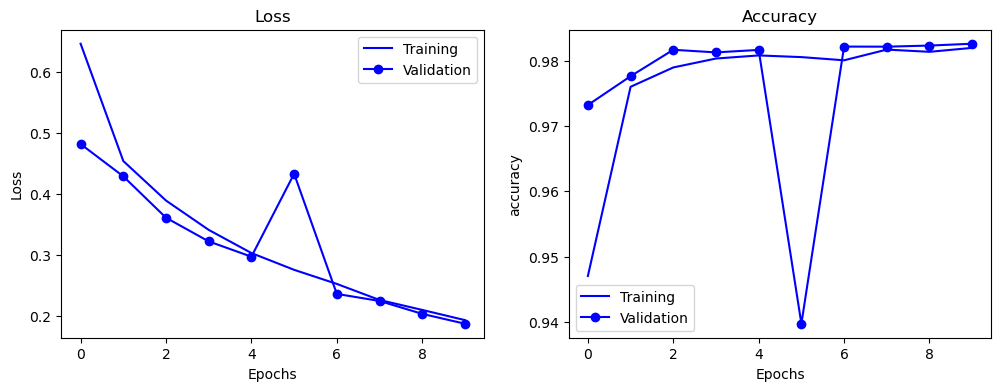

In [52]:
loss, val_loss = res['loss'], res['val_loss']
acc, val_acc = res['acc'], res['val_acc']
plot_acc_loss (loss, val_loss, acc, val_acc)

# Verify the Model

In [53]:
def model_loader(checkpoint_PATH, mod):
    
    if mod == True:
        uce_model = Unet_Client_Encoder_Mod(input_channel=1, output_channel=1, cut_layer = cut_layer) # M
        usw_model = Unet_Server_Widow_Mod(input_channel=1, output_channel=1, cut_layer = cut_layer) # M
        ucd_model = Unet_Client_Decoder_Mod(input_channel=1, output_channel=1, cut_layer = cut_layer) # M
        
    else:
        uce_model = Unet_Client_Encoder(input_channel=1, output_channel=1) # M
        usw_model = Unet_Server_Widow(input_channel=1, output_channel=1) # M
        ucd_model = Unet_Client_Decoder(input_channel=1, output_channel=1) # M
    
    uce_model.load_state_dict(torch.load(checkpoint_PATH + "_client_encoder.pth")) 
    usw_model.load_state_dict(torch.load(checkpoint_PATH + "_server.pth")) 
    ucd_model.load_state_dict(torch.load(checkpoint_PATH + "_client_decoder.pth")) 
    
    uce_model = uce_model.to(device) # M
    usw_model = usw_model.to(device) # M
    ucd_model = ucd_model.to(device) # M

    models = [uce_model, usw_model, ucd_model]
    
    
    return models

In [54]:
def united_model(checkpoint_PATH, x, mod): # Given the Models and input, return the prediction
    
    models = model_loader(checkpoint_PATH, mod)
    
    client_enc, server, client_dec = models
    
    x1, skip = uce_model(x) # Client Encoder
    x2 = usw_model(x1) # Server (Black Widow Symbol)
    y_pred = ucd_model(x2, skip) # Client Decoder
    
    return y_pred
    

In [55]:
with torch.no_grad():
    for x, y in valid_dl:
        x = x.to(device, dtype=torch.float32)
        y = y.to(device, dtype=torch.float32)

        y_pred = united_model(checkpoint_PATH, x, mod = mod)
        break

In [56]:
pred = y_pred.cpu().numpy()
ynum = y.cpu().numpy()

pred.shape, ynum.shape

((8, 1, 256, 256), (8, 1, 256, 256))

In [57]:
pred = pred.reshape(len(pred), dim, dim)
ynum = ynum.reshape(len(ynum), dim, dim)

pred = pred > 0.5
pred = np.array(pred, dtype=np.uint8)

ynum = ynum > 0.5
ynum = np.array(ynum, dtype=np.uint8)

pred.shape, ynum.shape

((8, 256, 256), (8, 256, 256))

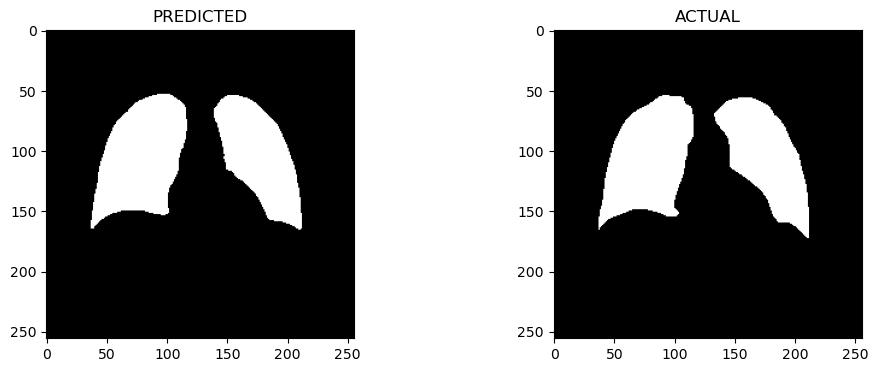

In [58]:
index = np.random.choice (len (pred))

plt.figure(figsize = (12, 4))

plt.subplot(1, 2, 1)
plt.title("PREDICTED")
plt.imshow(pred[index], cmap='gray')

plt.subplot(1, 2, 2)
plt.title("ACTUAL")
plt.imshow(ynum[index], cmap='gray')